In [9]:
import os
import yaml
import pandas as pd
import numpy as np
import json
import requests
import pickle
import Levenshtein
from collections import defaultdict
pd.set_option('display.max_columns', None)
import jellyfish
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error



In [2]:
folder_path = 'data/csv_data/IPL/match_ball'
all_matches_data_list=[]

In [3]:
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        with open(os.path.join(folder_path, filename), 'r') as f:
            data = pd.read_csv(f)
        all_matches_data_list.append(data)
            

In [4]:
ball_df=all_matches_data_list[0]
match_df=all_matches_data_list[1]

In [5]:
ball_df['extra_type']=ball_df['extra_type'].fillna('legal')
ball_df['player_out']=ball_df['extra_type'].fillna('No')
ball_df['kind']=ball_df['kind'].fillna('Not Out')
ball_df['fielders_involved']=ball_df['fielders_involved'].fillna('NA')
ball_df.isna().sum()

ID                   0
innings              0
overs                0
ballnumber           0
batter               0
bowler               0
non-striker          0
extra_type           0
batsman_run          0
extras_run           0
total_run            0
non_boundary         0
isWicketDelivery     0
player_out           0
kind                 0
fielders_involved    0
BattingTeam          0
dtype: int64

In [6]:
match_df_=match_df.drop('City',axis=1)
match_df_['SuperOver']=match_df_['SuperOver'].fillna('N')
match_df_['WinningTeam']=match_df_['WinningTeam'].fillna('NA')
match_df_['Player_of_Match']=match_df_['Player_of_Match'].fillna('NA')
match_df_['Margin']=match_df_['Margin'].fillna(0)
match_df_['method']=match_df_['method'].fillna('NA')


In [7]:
team_1=match_df_['Team1'].unique()
team_2=match_df_['Team2'].unique()
batting_team=ball_df['BattingTeam'].unique()
team_dic={'Kings XI Punjab':'Punjab Kings','Delhi Daredevils':'Delhi Capitals','Pune Warriors':'Rising Pune Supergiants',
           'Deccan Chargers':'Sunrisers Hyderabad','Gujarat Lions':'Gujarat Titans',
            'Rising Pune Supergiant':'Rising Pune Supergiants'}
#batting_team

In [8]:
match_df_['Team1'] = match_df_['Team1'].replace(team_dic)
match_df_['Team2'] = match_df_['Team2'].replace(team_dic)
match_df_['TossWinner'] = match_df_['TossWinner'].replace(team_dic)


ball_df['BattingTeam'] = ball_df['BattingTeam'].replace(team_dic)
batting_team=match_df_['Team1'].unique()
batting_team

array(['Rajasthan Royals', 'Royal Challengers Bangalore',
       'Sunrisers Hyderabad', 'Delhi Capitals', 'Chennai Super Kings',
       'Gujarat Titans', 'Lucknow Super Giants', 'Kolkata Knight Riders',
       'Punjab Kings', 'Mumbai Indians', 'Rising Pune Supergiants',
       'Kochi Tuskers Kerala'], dtype=object)

In [10]:
venue_name_replacements = {
    'Narendra Modi Stadium, Ahmedabad': 'Narendra Modi Stadium',
    'Eden Gardens, Kolkata': 'Eden Gardens',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium',
    'Brabourne Stadium, Mumbai': 'Brabourne Stadium',
    'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy',
    'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
    'Dubai International Cricket Stadium': 'Dubai International Cricket Stadium',
    'Sharjah Cricket Stadium': 'Sharjah Cricket Stadium',
    'Zayed Cricket Stadium, Abu Dhabi': 'Zayed Cricket Stadium',
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium',
    'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
    'Sheikh Zayed Stadium': 'Sheikh Zayed Stadium',
    'Rajiv Gandhi International Stadium': 'Rajiv Gandhi International Stadium',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
    'MA Chidambaram Stadium': 'MA Chidambaram Stadium',
    'Punjab Cricket Association IS Bindra Stadium': 'Punjab Cricket Association IS Bindra Stadium',
    'M.Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
    'Arun Jaitley Stadium': 'Arun Jaitley Stadium',
    'Eden Gardens': 'Eden Gardens',
    'Sawai Mansingh Stadium': 'Sawai Mansingh Stadium',
    'Maharashtra Cricket Association Stadium': 'Maharashtra Cricket Association Stadium',
    'Holkar Cricket Stadium': 'Holkar Cricket Stadium',
    'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
    'M Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
    'Feroz Shah Kotla': 'Feroz Shah Kotla',
    'Green Park': 'Green Park',
    'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
    'Saurashtra Cricket Association Stadium': 'Saurashtra Cricket Association Stadium',
    'Shaheed Veer Narayan Singh International Stadium': 'Shaheed Veer Narayan Singh International Stadium',
    'JSCA International Stadium Complex': 'JSCA International Stadium Complex',
    'Brabourne Stadium': 'Brabourne Stadium',
    'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association Stadium',
    'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
    'Sardar Patel Stadium, Motera': 'Sardar Patel Stadium',
    'Barabati Stadium': 'Barabati Stadium',
    'Subrata Roy Sahara Stadium': 'Subrata Roy Sahara Stadium',
    'Himachal Pradesh Cricket Association Stadium': 'Himachal Pradesh Cricket Association Stadium',
    'Dr DY Patil Sports Academy': 'Dr DY Patil Sports Academy',
    'Nehru Stadium': 'Nehru Stadium',
    'Vidarbha Cricket Association Stadium, Jamtha': 'Vidarbha Cricket Association Stadium',
    'New Wanderers Stadium': 'New Wanderers Stadium',
    'SuperSport Park': 'SuperSport Park'
}

In [11]:

match_df_['Venue'] = match_df_['Venue'].replace(venue_name_replacements)
venues=match_df_['Venue'].unique()
#venues


In [12]:
ball_df['extra_type']=ball_df['extra_type'].fillna('legal')
ball_df['player_out']=ball_df['extra_type'].fillna('No')
ball_df['kind']=ball_df['kind'].fillna('Not Out')
ball_df['fielders_involved']=ball_df['fielders_involved'].fillna('NA')
ball_df.isna().sum()

ID                   0
innings              0
overs                0
ballnumber           0
batter               0
bowler               0
non-striker          0
extra_type           0
batsman_run          0
extras_run           0
total_run            0
non_boundary         0
isWicketDelivery     0
player_out           0
kind                 0
fielders_involved    0
BattingTeam          0
dtype: int64

In [13]:
merged_df = match_df.merge(ball_df, on='ID')
merged_df['Venue'] = merged_df['Venue'].replace(venue_name_replacements)
# Printing the merged dataframe
print(merged_df.isna().sum())

ID                        0
City                  12397
Date                      0
Season                    0
MatchNumber               0
Team1                     0
Team2                     0
Venue                     0
TossWinner                0
TossDecision              0
SuperOver               372
WinningTeam             372
WonBy                     0
Margin                 4006
method               222746
Player_of_Match         372
Team1Players              0
Team2Players              0
Umpire1                   0
Umpire2                   0
innings                   0
overs                     0
ballnumber                0
batter                    0
bowler                    0
non-striker               0
extra_type                0
batsman_run               0
extras_run                0
total_run                 0
non_boundary              0
isWicketDelivery          0
player_out                0
kind                      0
fielders_involved         0
BattingTeam         

In [14]:
merged_df=merged_df.drop('City',axis=1)
merged_df['SuperOver']=merged_df['SuperOver'].fillna('N')
merged_df['WinningTeam']=merged_df['WinningTeam'].fillna('NA')
merged_df['Player_of_Match']=merged_df['Player_of_Match'].fillna('NA')
merged_df['Margin']=merged_df['Margin'].fillna(0)
merged_df['method']=merged_df['method'].fillna('NA')
merged_df.isna().sum()

ID                   0
Date                 0
Season               0
MatchNumber          0
Team1                0
Team2                0
Venue                0
TossWinner           0
TossDecision         0
SuperOver            0
WinningTeam          0
WonBy                0
Margin               0
method               0
Player_of_Match      0
Team1Players         0
Team2Players         0
Umpire1              0
Umpire2              0
innings              0
overs                0
ballnumber           0
batter               0
bowler               0
non-striker          0
extra_type           0
batsman_run          0
extras_run           0
total_run            0
non_boundary         0
isWicketDelivery     0
player_out           0
kind                 0
fielders_involved    0
BattingTeam          0
dtype: int64

In [15]:
# Group the data by match id and inning
grouped_data = merged_df.groupby(['ID', 'innings'])

# Create an empty list to store the powerplay data
batter_powerplay_data = []
bowler_powerplay_data = []
powerplay_data=[]
# Loop through each group
for name, group in grouped_data:
    #print(name)
    #print(group)
    # Filter out the ball-by-ball data for the first 6 overs of the innings
    powerplay = group.loc[group['overs'] <= 5]
    
    total_powerplay_score=powerplay.groupby(['ID','innings'])['total_run'].sum()
    #print(total_powerplay_score.values)
    
    # Calculate the total runs and balls faced by each batsman
    runs = powerplay.groupby('batter')['batsman_run'].sum()
    balls_faced = powerplay.groupby('batter')['isWicketDelivery'].count()
    
    # Calculate the strike rate of each batsman
    batter_strike_rate = (runs / balls_faced) * 100
    #print(batter_strike_rate)
    
    # Calculate the total runs and overs bowled by each bowler
    runs_conceded = powerplay.groupby('bowler')['total_run'].sum()
    overs_bowled = powerplay.groupby('bowler')['overs'].nunique()
    wicket_taken = powerplay.groupby('bowler')['isWicketDelivery'].sum()
    # Calculate the economy rate of each bowler
    economy_rate = runs_conceded / overs_bowled
    bowler_strike_rate = overs_bowled*6 / wicket_taken
    
    #print(strike_rate.index)
    #print(economy_rate)
    
    #print(bowler_strike_rate)
    #print
    #'''
    #try:
    # Create a new dataframe with the powerplay statistics
    powerplay_score=pd.DataFrame({
        'Powerplay Score': total_powerplay_score.values
    })
    powerplay_score['ID']=name[0]
    powerplay_score['Innings']=name[1]
    
    batter_powerplay_stats = pd.DataFrame({
        'Batsman': batter_strike_rate.index,
        'Batter Strike Rate': batter_strike_rate.values
    })
    batter_powerplay_stats['ID']=name[0]
    batter_powerplay_stats['Innings']=name[1]

    #print(batter_powerplay_stats)

    bowler_powerplay_stats = pd.DataFrame({
        'Bowler': economy_rate.index,
        'Economy Rate': economy_rate.values,
        'Bowler Strike Rate': bowler_strike_rate.values,
    })

    bowler_powerplay_stats['ID']=name[0]
    bowler_powerplay_stats['Innings']=name[1]
        
        #print(bowler_powerplay_stats)
        
    #except ValueError as e:
        #print('Match ID',name[0])
        #print('Inning',name[1])
        #break
        #print(e)
        #print(batter_powerplay_stats)
        #print(bowler_powerplay_stats)
    
    # Append the powerplay statistics to the powerplay data list
    powerplay_data.append(powerplay_score)
    batter_powerplay_data.append(batter_powerplay_stats)
    bowler_powerplay_data.append(bowler_powerplay_stats)

# Concatenate the powerplay data into a single dataframe

#'''


In [16]:
batter_powerplay=pd.concat(batter_powerplay_data)
bowler_powerplay=pd.concat(bowler_powerplay_data)
total_powerplay=pd.concat(powerplay_data)

#print(batter_powerplay.columns)
#print(bowler_powerplay.columns)



powerplay_df = pd.merge(batter_powerplay,bowler_powerplay,on=['ID','Innings'])
powerplay_df = pd.merge(powerplay_df,total_powerplay,on=['ID','Innings'])

#print(powerplay_df.columns)


powerplay_stats_df = powerplay_df.merge(match_df_, on=['ID'])

powerplay_stats_df

,Batsman,Batter Strike Rate,ID,Innings,Bowler,Economy Rate,Bowler Strike Rate,Powerplay Score,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2
0,BB McCullum,186.363636,335982,1,AA Noffke,23.000000,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
1,BB McCullum,186.363636,335982,1,P Kumar,6.333333,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
2,BB McCullum,186.363636,335982,1,Z Khan,9.500000,12.0,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
3,RT Ponting,0.000000,335982,1,AA Noffke,23.000000,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
4,RT Ponting,0.000000,335982,1,P Kumar,6.333333,inf,61,2008-04-18,2007/08,1,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,N,Kolkata Knight Riders,Runs,140.0,NA,BB McCullum,"['R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis...","['SC Ganguly', 'BB McCullum', 'RT Ponting', 'D...",Asad Rauf,RE Koertzen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22403,Shubman Gill,71.428571,1312200,2,TA Boult,2.666667,18.0,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
22404,Shubman Gill,71.428571,1312200,2,YS Chahal,6.000000,inf,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
22405,WP Saha,71.428571,1312200,2,M Prasidh Krishna,8.500000,12.0,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
22406,WP Saha,71.428571,1312200,2,TA Boult,2.666667,18.0,31,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,Narendra Modi Stadium,Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NA,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon


In [23]:
median_batter_powerplay=batter_powerplay.groupby(['ID','Innings']).agg({'Batter Strike Rate':'median'}).reset_index()
median_bowler_powerplay=bowler_powerplay.groupby(['ID','Innings']).agg({'Economy Rate':'median'}).reset_index()
#total_powerplay
#median_batter_powerplay

In [47]:
powerplay_stats_df_v2 = total_powerplay.merge(median_batter_powerplay, on=['ID','Innings'])
powerplay_stats_df_v2 = powerplay_stats_df_v2.merge(median_bowler_powerplay, on=['ID','Innings'])
powerplay_stats_df_v2 = powerplay_stats_df_v2.merge(match_df_, on=['ID'])




In [48]:
def fetch_batting_team(r):
    if((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team2']
    
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    if((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team2']

def fetch_bowling_team(r):
    if((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==1) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==1) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team1']
    
    if((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team1'])):
        return r['Team1']
    elif((r['Innings']==2) and (r['TossDecision']=='bat') and (r['TossWinner']==r['Team2'])):
        return r['Team2']
    
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team1'])):
        return r['Team2']
    elif((r['Innings']==2) and (r['TossDecision']=='field') and (r['TossWinner']==r['Team2'])):
        return r['Team1']

In [49]:
#venue	innings	batting_team	bowling_team	batsmen	bowlers
#MA Chidambaram Stadium	1	Mumbai Indians	Kolkata Knight Riders	Quinton de Kock, Rohit Sharma, Suryakumar Yadav	Harbhajan Singh, Varun Chakravarthy, Shakib Al Hasan, Pat Cummins
#MA Chidambaram Stadium	2	Kolkata Knight Riders	Mumbai Indians	Harbhajan Singh, Varun Chakravarthy, Shakib Al Hasan, Pat Cummins	Quinton de Kock, Rohit Sharma, Suryakumar Yadav


powerplay_stats_df_v2['Team1']=powerplay_stats_df_v2['Team1'].replace(team_dic)
powerplay_stats_df_v2['Team2']=powerplay_stats_df_v2['Team2'].replace(team_dic)
powerplay_stats_df_v2['batting_team']=powerplay_stats_df_v2.apply(fetch_batting_team,axis=1)
powerplay_stats_df_v2['bowling_team']=powerplay_stats_df_v2.apply(fetch_bowling_team,axis=1)

powerplay_stats_df_v2['TossWinner']=powerplay_stats_df_v2['TossWinner'].replace(team_dic)
powerplay_stats_df_v2['batting_team']=powerplay_stats_df_v2['batting_team'].replace(team_dic)
powerplay_stats_df_v2['bowling_team']=powerplay_stats_df_v2['bowling_team'].replace(team_dic)

powerplay_stats_df_v2['batting_team'].unique()
powerplay_stats_df_v2[powerplay_stats_df_v2['batting_team'].isna()]                                                                                                       

,Powerplay Score,ID,Innings,Batter Strike Rate,Economy Rate,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2,batting_team,bowling_team
134,15,392190,3,158.333333,15.0,2009-04-23,2009,10,Kolkata Knight Riders,Rajasthan Royals,Newlands,Kolkata Knight Riders,field,Y,Rajasthan Royals,SuperOver,0.0,NA,YK Pathan,"['CH Gayle', 'BB McCullum', 'LR Shukla', 'BJ H...","['GC Smith', 'PC Valthaty', 'RJ Quiney', 'YK P...",MR Benson,M Erasmus,None,None
135,18,392190,4,450.000000,18.0,2009-04-23,2009,10,Kolkata Knight Riders,Rajasthan Royals,Newlands,Kolkata Knight Riders,field,Y,Rajasthan Royals,SuperOver,0.0,NA,YK Pathan,"['CH Gayle', 'BB McCullum', 'LR Shukla', 'BJ H...","['GC Smith', 'PC Valthaty', 'RJ Quiney', 'YK P...",MR Benson,M Erasmus,None,None
264,9,419121,3,100.000000,9.0,2010-03-21,2009/10,16,Chennai Super Kings,Punjab Kings,MA Chidambaram Stadium,Chennai Super Kings,field,Y,Kings XI Punjab,SuperOver,0.0,NA,J Theron,"['PA Patel', 'ML Hayden', 'SK Raina', 'M Vijay...","['RS Bopara', 'IK Pathan', 'KC Sangakkara', 'D...",K Hariharan,DJ Harper,None,None
265,10,419121,4,250.000000,10.0,2010-03-21,2009/10,16,Chennai Super Kings,Punjab Kings,MA Chidambaram Stadium,Chennai Super Kings,field,Y,Kings XI Punjab,SuperOver,0.0,NA,J Theron,"['PA Patel', 'ML Hayden', 'SK Raina', 'M Vijay...","['RS Bopara', 'IK Pathan', 'KC Sangakkara', 'D...",K Hariharan,DJ Harper,None,None
661,20,598004,3,220.000000,20.0,2013-04-07,2013,7,Sunrisers Hyderabad,Royal Challengers Bangalore,Rajiv Gandhi International Stadium,Royal Challengers Bangalore,bat,Y,Sunrisers Hyderabad,SuperOver,0.0,NA,GH Vihari,"['PA Reddy', 'PA Patel', 'CL White', 'GH Vihar...","['CH Gayle', 'TM Dilshan', 'V Kohli', 'KK Nair...",AK Chaudhary,S Ravi,None,None
662,15,598004,4,250.000000,15.0,2013-04-07,2013,7,Sunrisers Hyderabad,Royal Challengers Bangalore,Rajiv Gandhi International Stadium,Royal Challengers Bangalore,bat,Y,Sunrisers Hyderabad,SuperOver,0.0,NA,GH Vihari,"['PA Reddy', 'PA Patel', 'CL White', 'GH Vihar...","['CH Gayle', 'TM Dilshan', 'V Kohli', 'KK Nair...",AK Chaudhary,S Ravi,None,None
689,15,598017,3,212.500000,15.0,2013-04-16,2013,21,Royal Challengers Bangalore,Delhi Capitals,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,Y,Royal Challengers Bangalore,SuperOver,0.0,NA,V Kohli,"['CH Gayle', 'KL Rahul', 'V Kohli', 'AB de Vil...","['DA Warner', 'V Sehwag', 'MC Juneja', 'DPMD J...",M Erasmus,VA Kulkarni,None,None
690,11,598017,4,0.000000,11.0,2013-04-16,2013,21,Royal Challengers Bangalore,Delhi Capitals,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,Y,Royal Challengers Bangalore,SuperOver,0.0,NA,V Kohli,"['CH Gayle', 'KL Rahul', 'V Kohli', 'AB de Vil...","['DA Warner', 'V Sehwag', 'MC Juneja', 'DPMD J...",M Erasmus,VA Kulkarni,None,None
841,11,729315,3,100.000000,11.0,2014-04-29,2014,19,Kolkata Knight Riders,Rajasthan Royals,Sheikh Zayed Stadium,Rajasthan Royals,bat,Y,Rajasthan Royals,SuperOver,0.0,NA,JP Faulkner,"['G Gambhir', 'MS Bisla', 'JH Kallis', 'MK Pan...","['AM Rahane', 'KK Nair', 'SV Samson', 'SR Wats...",Aleem Dar,AK Chaudhary,None,None
842,11,729315,4,183.333333,11.0,2014-04-29,2014,19,Kolkata Knight Riders,Rajasthan Royals,Sheikh Zayed Stadium,Rajasthan Royals,bat,Y,Rajasthan Royals,SuperOver,0.0,NA,JP Faulkner,"['G Gambhir', 'MS Bisla', 'JH Kallis', 'MK Pan...","['AM Rahane', 'KK Nair', 'SV Samson', 'SR Wats...",Aleem Dar,AK Chaudhary,None,None


In [50]:
powerplay_stats_df_v2.columns

Index(['Powerplay Score', 'ID', 'Innings', 'Batter Strike Rate',
       'Economy Rate', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2', 'batting_team', 'bowling_team'],
      dtype='object')

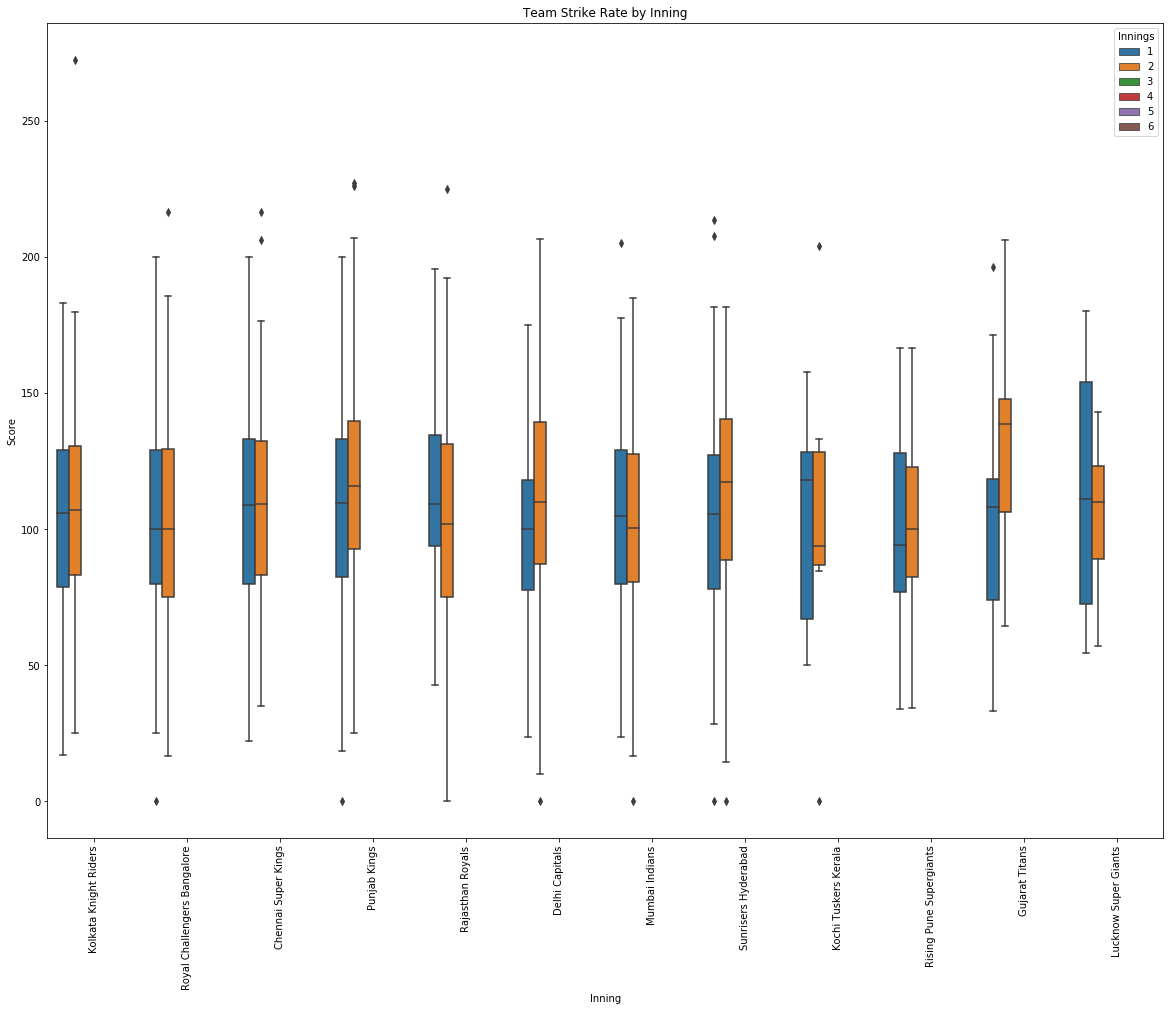

In [51]:
fig = plt.figure(figsize=(20, 15))
sns.boxplot(x='batting_team', y='Batter Strike Rate', hue='Innings', data=powerplay_stats_df_v2)
plt.xlabel('Inning')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.title('Team Strike Rate by Inning')
plt.show()

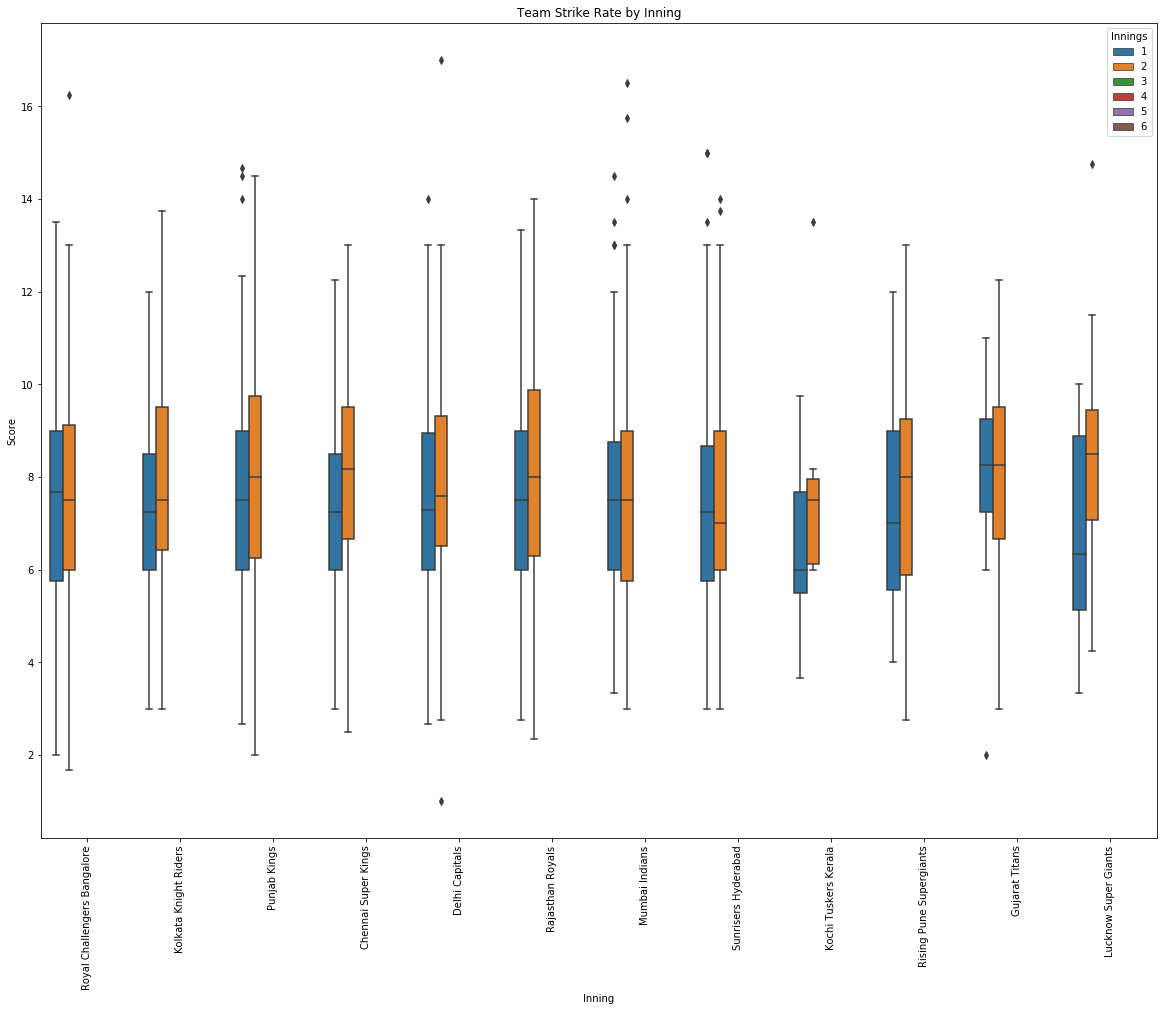

In [52]:
fig = plt.figure(figsize=(20, 15))
sns.boxplot(x='bowling_team', y='Economy Rate', hue='Innings', data=powerplay_stats_df_v2)
plt.xlabel('Inning')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.title('Team Strike Rate by Inning')
plt.show()

In [54]:
powerplay_stats_df_v2_=powerplay_stats_df_v2.drop(['Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1',
       'Umpire2'],axis=1)
powerplay_stats_df_v2.columns

Index(['Powerplay Score', 'ID', 'Innings', 'Batter Strike Rate',
       'Economy Rate', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2', 'batting_team', 'bowling_team'],
      dtype='object')

In [56]:

#drop rows with batting_team & bowling_team nan (ignore superovers)
final_powerplay_stats_df=powerplay_stats_df_v2_.dropna(subset=['batting_team', 'bowling_team'], inplace=False)
print(final_powerplay_stats_df.shape)
india_powerplay_data=final_powerplay_stats_df[~final_powerplay_stats_df['Season'].isin(['2009','2020/21'])]


train_features=['ID', 'Season','Innings','Powerplay Score', 'Venue','batting_team','bowling_team','Batter Strike Rate',
                'Economy Rate']

train_df=india_powerplay_data[train_features]

#train_df.isna().sum()
train_df


(1898, 20)


,ID,Season,Innings,Powerplay Score,Venue,batting_team,bowling_team,Batter Strike Rate,Economy Rate
0,335982,2007/08,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,83.333333,9.500000
1,335982,2007/08,2,26,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,41.666667,4.500000
2,335983,2007/08,1,53,Punjab Cricket Association Stadium,Chennai Super Kings,Punjab Kings,136.363636,10.500000
3,335983,2007/08,2,63,Punjab Cricket Association Stadium,Punjab Kings,Chennai Super Kings,162.777778,10.500000
4,335984,2007/08,1,40,Feroz Shah Kotla,Rajasthan Royals,Delhi Capitals,103.846154,4.333333
...,...,...,...,...,...,...,...,...,...
1923,1312198,2022,2,62,Eden Gardens,Lucknow Super Giants,Royal Challengers Bangalore,143.137255,10.666667
1924,1312199,2022,1,46,Narendra Modi Stadium,Royal Challengers Bangalore,Royal Challengers Bangalore,107.692308,7.666667
1925,1312199,2022,2,67,Narendra Modi Stadium,Rajasthan Royals,Royal Challengers Bangalore,161.538462,10.750000
1926,1312200,2022,1,44,Narendra Modi Stadium,Rajasthan Royals,Gujarat Titans,137.500000,7.250000


In [58]:
train_df.columns

Index(['ID', 'Season', 'Innings', 'Powerplay Score', 'Venue', 'batting_team',
       'bowling_team', 'Batter Strike Rate', 'Economy Rate'],
      dtype='object')

In [57]:
import scipy.stats as stats

C:\Users\Sawon\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


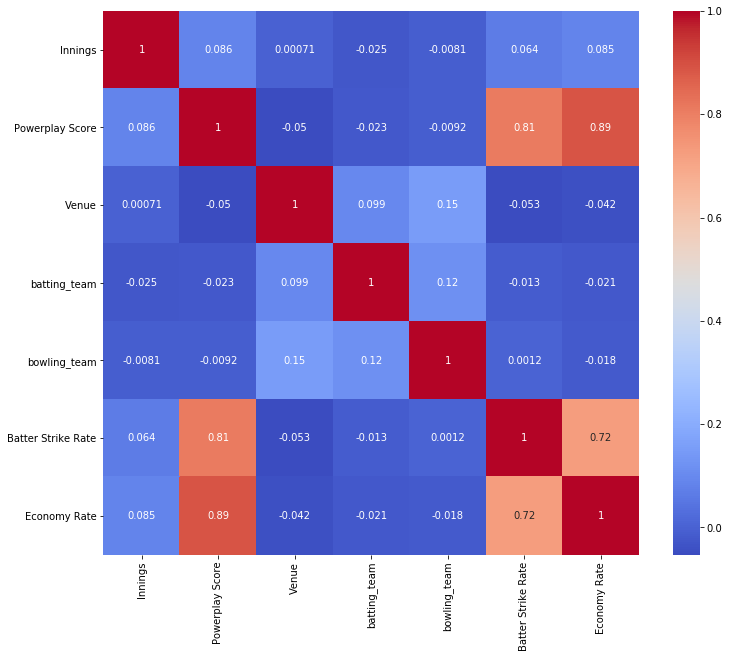

In [61]:
# Create label encoder object
le = LabelEncoder()
#sample_data_=train_df[train_df['Season'].isin(['2021','2022'])]
sample_data_=train_df
sample_data=sample_data_[['Innings', 'Powerplay Score', 'Venue', 'batting_team',
       'bowling_team', 'Batter Strike Rate', 'Economy Rate']]
# Iterate through all the columns of the dataframe and encode the categorical variables
for col in sample_data.columns:
    if sample_data[col].dtype == 'object':
        sample_data[col] = le.fit_transform(sample_data[col])

num_cols = sample_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
final_train_df_features_importance = sample_data[num_cols]

corr = sample_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True)

### Relationship Between Venue Batting Bowling Team & Venue

In [62]:
# Create a contingency table
data=train_df.copy(deep=True)
contingency_table = pd.crosstab(data["Venue"], [data["batting_team"], data["bowling_team"]])

# Perform chi-square test of independence
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print chi-square statistic, p-value, and degrees of freedom
print("Chi-Square Statistic: ", chi2_stat)
print("P-Value: ", p_value)
print("Degrees of Freedom: ", dof)

# Set significance level
alpha = 0.05

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant relationship between the three categorical variables.")
else:
    print("Fail to reject null hypothesis: There is no significant relationship between the three categorical variables.")

Chi-Square Statistic:  8492.274982833025
P-Value:  0.0
Degrees of Freedom:  3770
Reject null hypothesis: There is a significant relationship between the three categorical variables.


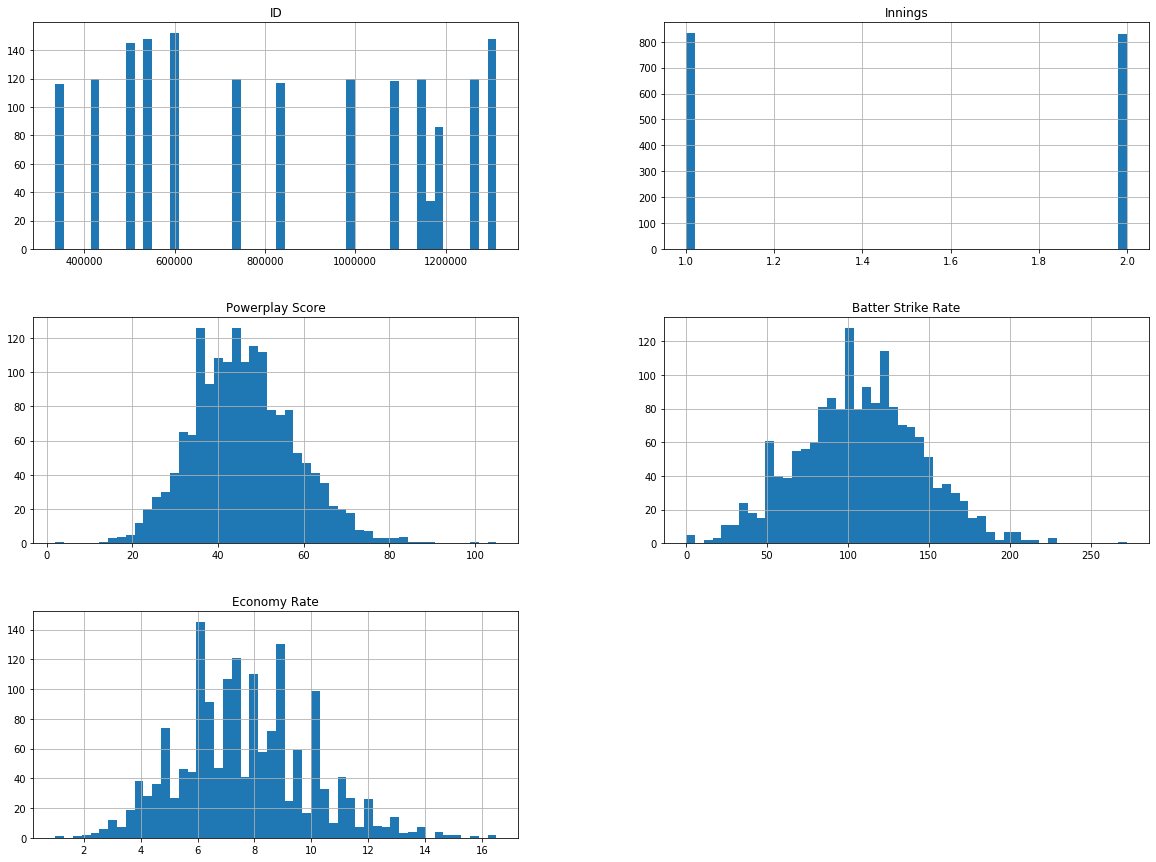

In [63]:
process_data_v0=train_df.copy(deep=True)
%matplotlib inline
import matplotlib.pyplot as plt
process_data_v0.hist(bins=50, figsize=(20,15))

plt.show()

In [64]:
train_df_eda=train_df.copy(deep=True)

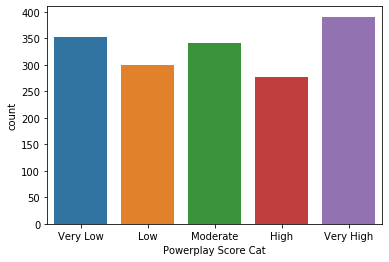

In [65]:
train_df_eda["Powerplay Score Cat"] = pd.cut(train_df_eda["Powerplay Score"],
                               bins=[train_df_eda['Powerplay Score'].min(),36,42,48,54,train_df_eda['Powerplay Score'].max()],
                               labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

sns.countplot(x='Powerplay Score Cat', data=train_df_eda)

In [66]:
train_df_eda.isna().sum()

ID                     0
Season                 0
Innings                0
Powerplay Score        0
Venue                  0
batting_team           0
bowling_team           0
Batter Strike Rate     0
Economy Rate           0
Powerplay Score Cat    1
dtype: int64

In [67]:
#train_df_eda[train_df_eda['Powerplay Score Cat'].isna()]
train_df_eda_=train_df_eda.dropna()
train_df_eda_

,ID,Season,Innings,Powerplay Score,Venue,batting_team,bowling_team,Batter Strike Rate,Economy Rate,Powerplay Score Cat
0,335982,2007/08,1,61,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,83.333333,9.500000,Very High
1,335982,2007/08,2,26,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,41.666667,4.500000,Very Low
2,335983,2007/08,1,53,Punjab Cricket Association Stadium,Chennai Super Kings,Punjab Kings,136.363636,10.500000,High
3,335983,2007/08,2,63,Punjab Cricket Association Stadium,Punjab Kings,Chennai Super Kings,162.777778,10.500000,Very High
4,335984,2007/08,1,40,Feroz Shah Kotla,Rajasthan Royals,Delhi Capitals,103.846154,4.333333,Low
...,...,...,...,...,...,...,...,...,...,...
1923,1312198,2022,2,62,Eden Gardens,Lucknow Super Giants,Royal Challengers Bangalore,143.137255,10.666667,Very High
1924,1312199,2022,1,46,Narendra Modi Stadium,Royal Challengers Bangalore,Royal Challengers Bangalore,107.692308,7.666667,Moderate
1925,1312199,2022,2,67,Narendra Modi Stadium,Rajasthan Royals,Royal Challengers Bangalore,161.538462,10.750000,Very High
1926,1312200,2022,1,44,Narendra Modi Stadium,Rajasthan Royals,Gujarat Titans,137.500000,7.250000,Moderate


### Split the Dataset

In [68]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_df_eda_, train_df_eda_["Powerplay Score Cat"]):
    strat_train_set = train_df_eda_.iloc[train_index]
    strat_test_set = train_df_eda_.iloc[test_index]

In [69]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Powerplay Score Cat", axis=1, inplace=True)

C:\Users\Sawon\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
match_details = strat_train_set.drop("Powerplay Score", axis=1) # drop labels for training set
powerplay_score = strat_train_set["Powerplay Score"].copy()

In [75]:
match_details=match_details.drop(['ID','Season','Economy Rate'],axis=1)


In [76]:
match_details['Innings']=match_details['Innings'].astype(str)
match_details

,Innings,Venue,batting_team,bowling_team,Batter Strike Rate
1262,1,Green Park,Gujarat Titans,Gujarat Titans,118.333333
1776,1,Sharjah Cricket Stadium,Delhi Capitals,Delhi Capitals,89.473684
1761,2,Dubai International Cricket Stadium,Mumbai Indians,Royal Challengers Bangalore,140.555556
1863,2,Maharashtra Cricket Association Stadium,Punjab Kings,Lucknow Super Giants,142.857143
777,1,JSCA International Stadium Complex,Rising Pune Supergiants,Kolkata Knight Riders,119.047619
...,...,...,...,...,...
608,2,Subrata Roy Sahara Stadium,Rising Pune Supergiants,Royal Challengers Bangalore,130.000000
1409,2,Wankhede Stadium,Mumbai Indians,Delhi Capitals,103.846154
1920,1,Eden Gardens,Rajasthan Royals,Rajasthan Royals,94.117647
75,2,Punjab Cricket Association Stadium,Rajasthan Royals,Punjab Kings,31.428571


### CUSTOM TRANSFORMER

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

num_attribs = ['Batter Strike Rate']
cat_attribs = ['Innings','Venue','batting_team','bowling_team']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

match_details_onehot_encoder = full_pipeline.fit_transform(match_details)
match_details_onehot_encoder.shape

(1330, 57)

## Simple Linear Regression

In [81]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(match_details_onehot_encoder, powerplay_score)

LinearRegression()

In [82]:
# let's try the full preprocessing pipeline on a few training instances
some_data = match_details.iloc[:5]
some_labels = powerplay_score.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Actual Score:", some_labels.values)

Predictions: [48.68569346 38.97187066 54.17067938 55.5656608  44.92464108]
Actual Score: [50 38 56 46 42]


In [83]:
from sklearn.metrics import mean_squared_error

score_predictions = lin_reg.predict(match_details_onehot_encoder)
lin_mse = mean_squared_error(powerplay_score, score_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6.8337180008737155

In [84]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(powerplay_score, score_predictions)
lin_mae

5.140849157002508

### Decision Tree

In [85]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(match_details_onehot_encoder, powerplay_score)

DecisionTreeRegressor(random_state=42)

In [86]:
score_predictions = tree_reg.predict(match_details_onehot_encoder)
tree_mse = mean_squared_error(powerplay_score, score_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.5802730322701115

### Better Evaluation Using Cross-Validation

In [87]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, match_details_onehot_encoder, powerplay_score,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [88]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 9.39934808 10.34444386 11.360878    9.20908391 11.97381228  8.8116251
  8.57472437  9.3015481   9.45308956 12.86248845]
Mean: 10.12910416979597
Standard deviation: 1.3824127186215176


In [89]:
lin_scores = cross_val_score(lin_reg, match_details_onehot_encoder, powerplay_score,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6.41276262 7.84108375 6.88103914 6.86748913 8.40310899 6.40069907
 7.02957644 6.57843849 7.64218888 7.0763408 ]
Mean: 7.113272731272678
Standard deviation: 0.6229264095335261


## Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(match_details_onehot_encoder, powerplay_score)

RandomForestRegressor(random_state=42)

In [91]:
score_predictions = forest_reg.predict(match_details_onehot_encoder)
forest_mse = mean_squared_error(powerplay_score, score_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


2.884867031672722

In [92]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, match_details_onehot_encoder, powerplay_score,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [6.78925949 8.00258264 6.88356219 7.44258633 9.20570225 6.83872775
 7.25228481 7.44808163 8.42871549 7.9825866 ]
Mean: 7.627408918411345
Standard deviation: 0.7405987251868126


In [93]:
scores = cross_val_score(lin_reg, match_details_onehot_encoder, powerplay_score, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    10.000000
mean      7.113273
std       0.656622
min       6.400699
25%       6.650701
50%       6.955308
75%       7.500727
max       8.403109
dtype: float64

In [94]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(match_details_onehot_encoder, powerplay_score)
score_predictions = svm_reg.predict(match_details_onehot_encoder)
svm_mse = mean_squared_error(powerplay_score, score_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

6.975881616105608

## Parameter Tuning


In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(match_details_onehot_encoder, powerplay_score)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [96]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [97]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

### Grid Search CV

In [98]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

10.368138618860044 {'max_features': 2, 'n_estimators': 3}
9.504584665562767 {'max_features': 2, 'n_estimators': 10}
9.059143302055938 {'max_features': 2, 'n_estimators': 30}
9.655739029378934 {'max_features': 4, 'n_estimators': 3}
8.626856811227753 {'max_features': 4, 'n_estimators': 10}
8.363361614615675 {'max_features': 4, 'n_estimators': 30}
9.778917938764785 {'max_features': 6, 'n_estimators': 3}
8.605784029729431 {'max_features': 6, 'n_estimators': 10}
8.142420129967707 {'max_features': 6, 'n_estimators': 30}
9.050034193768665 {'max_features': 8, 'n_estimators': 3}
8.080742402895597 {'max_features': 8, 'n_estimators': 10}
7.870059221316842 {'max_features': 8, 'n_estimators': 30}
10.73924341871201 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
9.743947128299586 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
10.110166512378061 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
9.406136259467141 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [99]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.028533,0.003677,0.004755,0.003884,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-88.116678,-112.683166,-100.141604,-119.593486,-116.956558,-107.498298,11.767780,17,-29.601563,-31.620102,-29.655493,-29.008029,-25.908347,-29.158707,1.848725
1,0.066545,0.014128,0.006537,0.003269,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-79.341372,-89.614199,-80.202001,-103.522417,-99.005659,-90.337130,9.727748,11,-17.915226,-17.669018,-16.855046,-16.094112,-14.487860,-16.604252,1.237307
2,0.175995,0.012453,0.004908,0.004012,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-67.380748,-74.896891,-75.302890,-99.212972,-93.546886,-82.068077,12.154191,9,-13.237629,-13.372150,-12.330967,-12.533740,-12.394856,-12.773868,0.440565
3,0.024755,0.004124,0.002071,0.003103,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-90.716896,-80.694027,-92.593150,-86.909171,-115.253237,-93.233296,11.737527,12,-29.166630,-29.672212,-24.418338,-23.822948,-24.160877,-26.248201,2.601086
4,0.078669,0.007383,0.002052,0.003100,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-67.397837,-64.084038,-75.334858,-78.210561,-87.085997,-74.422658,8.145866,6,-14.484067,-15.608876,-13.197073,-12.568496,-11.696450,-13.510993,1.387617
5,0.183946,0.013206,0.009980,0.003286,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-60.627719,-59.607072,-70.950518,-78.893614,-79.650165,-69.945817,8.590267,4,-12.051508,-12.063721,-10.376105,-10.215412,-10.236478,-10.988645,0.874565
6,0.028834,0.006403,0.006374,0.003188,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-82.096700,-96.880518,-84.209273,-96.351527,-118.598162,-95.627236,12.986178,14,-27.646907,-28.725052,-21.626149,-22.030423,-21.879264,-24.381559,3.127620
7,0.066158,0.006109,0.003254,0.003987,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-68.190448,-64.850349,-71.538651,-84.072681,-81.645466,-74.059519,7.528872,5,-14.411969,-13.691395,-11.597322,-11.834557,-10.952717,-12.497592,1.321116
8,0.220576,0.033319,0.008098,0.000179,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-57.685339,-57.641596,-67.223495,-71.893142,-77.051457,-66.299006,7.705975,3,-10.720801,-10.836076,-9.032161,-9.166793,-9.310091,-9.813184,0.793851
9,0.026846,0.002814,0.003198,0.003917,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-76.912803,-77.442565,-76.810777,-94.715260,-83.634190,-81.903119,6.897526,8,-23.459114,-25.099594,-23.113513,-21.824074,-16.631753,-22.025610,2.892133


### Randomized Search CV

In [100]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(match_details_onehot_encoder, powerplay_score)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD9D014F48>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD9D014548>},
                   random_state=42, scoring='neg_mean_squared_error')

In [103]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

10.368138618860044 {'max_features': 2, 'n_estimators': 3}
9.504584665562767 {'max_features': 2, 'n_estimators': 10}
9.059143302055938 {'max_features': 2, 'n_estimators': 30}
9.655739029378934 {'max_features': 4, 'n_estimators': 3}
8.626856811227753 {'max_features': 4, 'n_estimators': 10}
8.363361614615675 {'max_features': 4, 'n_estimators': 30}
9.778917938764785 {'max_features': 6, 'n_estimators': 3}
8.605784029729431 {'max_features': 6, 'n_estimators': 10}
8.142420129967707 {'max_features': 6, 'n_estimators': 30}
9.050034193768665 {'max_features': 8, 'n_estimators': 3}
8.080742402895597 {'max_features': 8, 'n_estimators': 10}
7.870059221316842 {'max_features': 8, 'n_estimators': 30}
10.73924341871201 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
9.743947128299586 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
10.110166512378061 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
9.406136259467141 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

7.867684030262933 {'max_features': 7, 'n_estimators': 180}
8.698273964845633 {'max_features': 5, 'n_estimators': 15}
8.603409800276719 {'max_features': 3, 'n_estimators': 72}
8.472141951382154 {'max_features': 5, 'n_estimators': 21}
7.89715431742283 {'max_features': 7, 'n_estimators': 122}
8.593202840176833 {'max_features': 3, 'n_estimators': 75}
8.589466010377853 {'max_features': 3, 'n_estimators': 88}
8.19492011865702 {'max_features': 5, 'n_estimators': 100}
8.595048220443335 {'max_features': 3, 'n_estimators': 150}
10.727354672160441 {'max_features': 5, 'n_estimators': 2}


In [105]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.65481757, 0.01003849, 0.01105294, 0.00474156, 0.00146605,
       0.01078078, 0.00497005, 0.00262908, 0.0029684 , 0.00737423,
       0.00612778, 0.00176926, 0.00332068, 0.00611782, 0.00413256,
       0.00841222, 0.00771271, 0.00634012, 0.00128835, 0.00127224,
       0.00371815, 0.0042947 , 0.00706169, 0.00257691, 0.00426794,
       0.00513362, 0.00192041, 0.00373057, 0.00623041, 0.00321829,
       0.00096854, 0.01072823, 0.00436977, 0.01244428, 0.00928638,
       0.00509788, 0.00387415, 0.01033447, 0.00167735, 0.01029447,
       0.01010361, 0.00860484, 0.0056488 , 0.00896739, 0.00941746,
       0.00896485, 0.00757807, 0.0031818 , 0.00298139, 0.01001087,
       0.00208212, 0.00871425, 0.01331777, 0.00918766, 0.0048803 ,
       0.00992213, 0.00787559])

## Final Score

In [111]:
final_model = rnd_search.best_estimator_

X_test_ = strat_test_set.drop("Powerplay Score", axis=1)
y_test = strat_test_set["Powerplay Score"].copy()



In [112]:
X_test_

,ID,Season,Innings,Venue,batting_team,bowling_team,Batter Strike Rate,Economy Rate
1826,1304070,2022,1,Dr DY Patil Sports Academy,Gujarat Titans,Gujarat Titans,112.500000,6.500000
82,336023,2007/08,1,Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,106.793478,9.000000
1908,1304111,2022,1,Wankhede Stadium,Sunrisers Hyderabad,Sunrisers Hyderabad,153.846154,8.500000
1283,1082650,2017,2,Rajiv Gandhi International Stadium,Rising Pune Supergiants,Mumbai Indians,50.000000,7.000000
838,729313,2014,2,Dubai International Cricket Stadium,Punjab Kings,Royal Challengers Bangalore,50.000000,7.000000
...,...,...,...,...,...,...,...,...
926,829705,2015,2,Eden Gardens,Kolkata Knight Riders,Mumbai Indians,75.000000,5.000000
328,419153,2009/10,1,MA Chidambaram Stadium,Kolkata Knight Riders,Chennai Super Kings,22.500000,3.666667
278,419128,2009/10,1,M Chinnaswamy Stadium,Delhi Capitals,Royal Challengers Bangalore,139.545455,10.750000
313,419145,2009/10,2,M Chinnaswamy Stadium,Sunrisers Hyderabad,Royal Challengers Bangalore,81.818182,5.833333


In [113]:
X_test=X_test_.drop(['ID','Season','Economy Rate'],axis=1)
X_test['Innings']=X_test['Innings'].astype(str)

In [114]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [115]:
print(final_rmse)

8.23643681959262


In [116]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([7.21958705, 9.14086133])

In [117]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(7.219587051266512, 9.140861325688459)

### End of Modelling V1 with 6 Features (Innings	Venue	batting_team	bowling_team	Batter Strike Rate	Economy Rate)

### Save the model